# Data Merge

#### 0. Load Data
Load raw data and required packages.

In [710]:
import pandas as pd
import numpy as np
import mpu
import json
import re  
import geopandas as gpd
import folium
# import pygeos
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

house = pd.read_csv('../data/house_combined.csv')
bus = pd.read_csv('../data/bus_stops_file.csv')
train = pd.read_csv('../data/train_stops_file.csv')
tram = pd.read_csv('../data/tram_stops_file.csv')
vline = pd.read_csv('../data/vline_stops_file.csv')
# population = pd.read_excel('../data/Population.xlsx')
# income = pd.read_excel('../data/Income.xlsx',sheet_name="Forecasted Income")
# male = pd.read_excel('../data/Sex & Age by Year.xlsx', sheet_name="Male")
# female = pd.read_excel('../data/Sex & Age by Year.xlsx', sheet_name="Female")
school = pd.read_csv('../data/school.csv',sep=",", encoding='cp1252')
hospital = pd.read_csv('../data/hospital_csv',sep=",", encoding='cp1252')
sc = pd.read_csv('../data/shopping_with_postcode.csv')
data_2019 = pd.read_csv('../data/2019_data.csv',sep=",", encoding='cp1252')
data_2020 = pd.read_csv('../data/2020_data.csv',sep=",", encoding='cp1252')
data_2021 = pd.read_csv('../data/2021_data.csv',sep=",", encoding='cp1252')
data_2022 = pd.read_csv('../data/2022_data.csv',sep=",", encoding='cp1252')
data_2022 = pd.read_csv('../data/2022_data.csv',sep=",", encoding='cp1252')
combine = pd.read_csv('../data/attribute_conbined.csv',sep=",", encoding='cp1252')
offence = pd.read_excel('../data/recorded offences.xlsx')
criminal = pd.read_excel('../data/criminal incidents2022-2013.xlsx')

#### 1. Property

1.1 Extract needed columns 

In [597]:
need_col = [
    "Unnamed: 0",
    "propertyTypes",
    "bathrooms",
    "bedrooms",
    "carspaces",
    "dateUpdated",
    "dateListed",
    "geoLocation",
    "landAreaSqm",
    "postcode",
    "surburb",
    'year', 
    'month',
    'price', 
    'bond',
    'rent'
]

init_house = house[need_col]
init_house.rename(columns={"Unnamed: 0":"index"}, inplace=True)
init_house["geoLocation"] = init_house["geoLocation"].apply(lambda x: re.sub('\'','\"', str(x)))
init_house = init_house[init_house["geoLocation"] != 'nan']
init_house['longitude'] = init_house['geoLocation'].apply(lambda d: json.loads(d)["longitude"])
init_house['latitude'] = init_house['geoLocation'].apply(lambda d: json.loads(d)["latitude"])

1.2 Add in SA2 code for later join

In [562]:
df =  gpd.read_file("../data/SA2 ERP GeoPackage 2021 (ASGS2021).gpkg")
df = df[(df['State_name_2021'] == 'Victoria' )]
df = df[['SA2_maincode_2021','geometry']]

In [598]:
datashp = gpd.GeoDataFrame(init_house, geometry=gpd.points_from_xy(init_house.longitude,init_house.latitude))
init_house = gpd.sjoin(datashp, df, how='inner', op='intersects')

In [599]:
combine = pd.read_csv('../data/attribute_conbined.csv',sep=",", encoding='cp1252')
combine.drop(['Unnamed: 0','surburb'], axis=1,inplace=True)
combine = combine.groupby('postcode', as_index=  False).sum()
combine

,postcode,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch
0,0,0.0,0.0,1.0,2.0,3.0,21.0,0.0,2.0,4.0,0.0,0.0,25.0,7.0,31.0
1,3000,31.0,20.0,0.0,8.0,1.0,56.0,13.0,4.0,3.0,0.0,3.0,15.0,4.0,6.0
2,3002,102.0,19.0,0.0,1.0,1.0,55.0,8.0,10.0,1.0,0.0,30.0,23.0,4.0,8.0
3,3003,150.0,40.0,2.0,27.0,14.0,422.0,49.0,18.0,34.0,0.0,10.0,94.0,59.0,144.0
4,3004,86.0,50.0,0.0,10.0,1.0,128.0,86.0,6.0,2.0,8.0,46.0,28.0,6.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,3977,74.0,48.0,2.0,62.0,12.0,552.0,64.0,29.0,45.0,10.0,19.0,172.0,65.0,308.0
475,3978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
476,3980,29.0,18.0,3.0,18.0,2.0,118.0,14.0,7.0,13.0,0.0,4.0,26.0,18.0,61.0
477,3981,60.0,17.0,1.0,50.0,10.0,237.0,22.0,22.0,23.0,0.0,7.0,129.0,66.0,150.0


In [640]:
d = init_house.merge(combine, on = 'postcode', how = 'left')
d

,index,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch
0,0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0
1,9,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0
2,10,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0
3,11,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0
4,21,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,144.949687,-37.837520,POINT (144.94969 -37.83752),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114955,116020,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,147.493795,-36.536581,POINT (147.49379 -36.53658),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114956,116027,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,147.494529,-36.536194,POINT (147.49453 -36.53619),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114957,116052,['house'],1.0,3.0,2.0,2022-08-31T04:22:36.17Z,2022-08-18T06:04:32Z,"{""latitude"": -36.2218206, ""longitude"": 147.258...",NaN,3700,tallangatta,2022,8,$470,NaN,470.0,147.258393,-36.221821,POINT (147.25839 -36.22182),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114958,116246,['house'],1.0,3.0,2.0,2021-03-09T00:53:53.08Z,2021-02-15T22:36:56Z,"{""latitude"": -36.2147158, ""longitude"": 147.177...",NaN,3700,tallangatta,2021,3,$310 per week,NaN,310.0,147.177222,-36.214716,POINT (147.17722 -36.21472),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
bus = pd.read_csv('../data/bus_stops_file.csv')
bus_result = []
for index, values in bus.iterrows():
    postcode = values['postcode']
    if pd.isna(postcode):
        stop_suburb = values['stop_suburb']
        suburb_list = stop_suburb.split(' ')
        postcode_str = suburb_list[1]
        if postcode_str.startswith('('):
            postcode_str = postcode_str.split('(')[1]
            if postcode_str.endswith(')'):
                postcode_str = postcode_str.split(')')[0]
                if postcode_str.isnumeric():
                    bus_result.append([values['stop_suburb'],values['stop_latitude'],values['stop_longitude'],postcode_str])
    else:
        bus_result.append([values['stop_suburb'],values['stop_latitude'],values['stop_longitude'],postcode])
                    
      

In [623]:
bus = pd.DataFrame(bus_result, columns= ['stop_suburb','stop_latitude','stop_longitude','postcode'])
bus['postcode'] = bus["postcode"].apply(lambda x: int(x))
bus

,stop_suburb,stop_latitude,stop_longitude,postcode
0,avondale heights,-37.762234,144.859680,3034
1,maribyrnong,-37.769444,144.872772,3032
2,avondale heights,-37.769413,144.857254,3034
3,maribyrnong,-37.769013,144.877823,3032
4,avondale heights,-37.759260,144.857391,3034
...,...,...,...,...
17872,hampton park,-38.030907,145.258270,3976
17873,hampton park,-38.042637,145.270248,3976
17874,narre warren south,-38.050587,145.296158,3805
17875,hampton park,-38.039837,145.280609,3976


In [486]:
bus_dict = dict()
for index, value in bus.iterrows():
    postcode = value['postcode']
    value_list = bus_dict.get(postcode,[])
    value_list.append(value)
    bus_dict[postcode] = value_list
 

In [ ]:
from math import radians, cos, sin, asin, sqrt
bus_distance_list = []
bus_count_list = []
for index, value in d.iterrows():
    postcode = value['postcode']
    longtitude = value['longitude']
    latitude = value['latitude']
    dis = 100000000
    bus_stops = bus_dict.get(postcode)
    if bus_stops is None:
        print(postcode)
        bus_count_list.append(0)
        bus_distance_list.append(None)
        continue
    else:
        bus_count_list.append(len(bus_stops))
    for i in bus_dict[postcode]:
        stop_latitude = i['stop_latitude']
        stop_longitude = i['stop_longitude']
        lng1, lat1, lng2, lat2 = map(radians, [float(longtitude), float(latitude), float(stop_longitude), float(stop_latitude)])
        dlon=lng2-lng1
        dlat=lat2-lat1
        a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        distance=2*asin(sqrt(a))*6371*1000 
        distance=round(distance/1000,3)
        if (distance < dis):
            dis = distance
    bus_distance_list.append(dis)
    

In [641]:
d['bus_count'] = bus_count_list
d['bus_distance'] = bus_distance_list
d

,index,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance
0,0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375
1,9,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730
2,10,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766
3,11,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209
4,21,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,144.949687,-37.837520,POINT (144.94969 -37.83752),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114955,116020,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,147.493795,-36.536581,POINT (147.49379 -36.53658),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.649
114956,116027,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,147.494529,-36.536194,POINT (147.49453 -36.53619),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.627
114957,116052,['house'],1.0,3.0,2.0,2022-08-31T04:22:36.17Z,2022-08-18T06:04:32Z,"{""latitude"": -36.2218206, ""longitude"": 147.258...",NaN,3700,tallangatta,2022,8,$470,NaN,470.0,147.258393,-36.221821,POINT (147.25839 -36.22182),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7.265
114958,116246,['house'],1.0,3.0,2.0,2021-03-09T00:53:53.08Z,2021-02-15T22:36:56Z,"{""latitude"": -36.2147158, ""longitude"": 147.177...",NaN,3700,tallangatta,2021,3,$310 per week,NaN,310.0,147.177222,-36.214716,POINT (147.17722 -36.21472),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.234


In [642]:
d = d[d['postcode'] != 0]
d

,index,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance
0,0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375
1,9,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730
2,10,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766
3,11,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209
4,21,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,144.949687,-37.837520,POINT (144.94969 -37.83752),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114955,116020,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,147.493795,-36.536581,POINT (147.49379 -36.53658),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.649
114956,116027,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,147.494529,-36.536194,POINT (147.49453 -36.53619),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.627
114957,116052,['house'],1.0,3.0,2.0,2022-08-31T04:22:36.17Z,2022-08-18T06:04:32Z,"{""latitude"": -36.2218206, ""longitude"": 147.258...",NaN,3700,tallangatta,2022,8,$470,NaN,470.0,147.258393,-36.221821,POINT (147.25839 -36.22182),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7.265
114958,116246,['house'],1.0,3.0,2.0,2021-03-09T00:53:53.08Z,2021-02-15T22:36:56Z,"{""latitude"": -36.2147158, ""longitude"": 147.177...",NaN,3700,tallangatta,2021,3,$310 per week,NaN,310.0,147.177222,-36.214716,POINT (147.17722 -36.21472),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.234


In [644]:
d[['postcode','bus_count']].drop_duplicates()

,postcode,bus_count
0,3205,10
48,3206,9
152,3207,69
256,3004,3
939,3006,11
...,...,...
114938,3636,0
114946,3260,4
114948,3700,1
114949,3701,1


In [645]:
school = pd.read_csv('../data/school.csv',sep=",", encoding='cp1252')
school_result = []
for index, values in school.iterrows():
    postcode = values['Postal_Postcode']
    school_result.append([values['X'],values['Y'],postcode])
school = pd.DataFrame(school_result, columns= ['school_longitude','school_latitude','postcode'])
school['postcode'] = school["postcode"].apply(lambda x: int(x))
school

,school_longitude,school_latitude,postcode
0,146.666601,-38.617713,3971
1,142.590393,-38.386281,3277
2,143.475649,-37.084502,3467
3,145.234722,-36.901368,3664
4,145.213980,-37.742675,3113
...,...,...,...
2286,144.966417,-37.837469,3205
2287,145.961611,-38.141528,3820
2288,144.923692,-37.675751,3047
2289,144.285354,-38.171776,3221


In [646]:
school_dict = dict()
for index, value in school.iterrows():
    postcode = value['postcode']
    value_list = school_dict.get(postcode,[])
    value_list.append(value)
    school_dict[postcode] = value_list

In [ ]:
from math import radians, cos, sin, asin, sqrt
school_distance_list = []
school_count_list = []
for index, value in d.iterrows():
    print(index)
    postcode = value['postcode']
    longtitude = value['longitude']
    latitude = value['latitude']
    dis = 100000000
    school_l = school_dict.get(postcode)
    if school_l is None:
        school_count_list.append(0)
        school_distance_list.append(None)
        continue
    else:
        school_count_list.append(len(school_l))
    for i in school_l:
        school_latitude = i['school_latitude']
        school_longitude = i['school_longitude']
        lng1, lat1, lng2, lat2 = map(radians, [float(longtitude), float(latitude), float(school_longitude), float(school_latitude)])
        dlon=lng2-lng1
        dlat=lat2-lat1
        a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        distance=2*asin(sqrt(a))*6371*1000 
        distance=round(distance/1000,3)
        if (distance < dis):
            dis = distance
    school_distance_list.append(dis)

In [656]:
# init_house['school_distance'] = school_distance_list
d['school_count'] = school_count_list
d['school_distance'] = school_distance_list

In [660]:
d = d[d['school_distance']>0]
d

,index,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance,school_count,school_distance
0,0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375,3,0.577
1,9,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730,3,0.299
2,10,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766,3,0.579
3,11,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209,3,0.165
4,21,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,144.949687,-37.837520,POINT (144.94969 -37.83752),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143,3,0.475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114955,116020,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,147.493795,-36.536581,POINT (147.49379 -36.53658),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.649,2,10.219
114956,116027,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,147.494529,-36.536194,POINT (147.49453 -36.53619),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.627,2,10.283
114957,116052,['house'],1.0,3.0,2.0,2022-08-31T04:22:36.17Z,2022-08-18T06:04:32Z,"{""latitude"": -36.2218206, ""longitude"": 147.258...",NaN,3700,tallangatta,2022,8,$470,NaN,470.0,147.258393,-36.221821,POINT (147.25839 -36.22182),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7.265,3,7.593
114958,116246,['house'],1.0,3.0,2.0,2021-03-09T00:53:53.08Z,2021-02-15T22:36:56Z,"{""latitude"": -36.2147158, ""longitude"": 147.177...",NaN,3700,tallangatta,2021,3,$310 per week,NaN,310.0,147.177222,-36.214716,POINT (147.17722 -36.21472),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.234,3,0.271


In [661]:
house_df = d.reset_index().drop('index', axis = 1)
house_df = house_df.reset_index().drop('level_0', axis = 1)

In [665]:
tram = pd.read_csv('../data/tram_stops_file.csv')
tram = tram[['stop_suburb',	'stop_latitude'	,'stop_longitude','postcode']]
tram_dict = dict()
for index, value in tram.iterrows():
    postcode = value['postcode']
    value_list = tram_dict.get(postcode,[])
    value_list.append(value)
    tram_dict[postcode] = value_list

In [667]:
house_df

,index,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance,school_count,school_distance
0,0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375,3,0.577
1,1,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730,3,0.299
2,2,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766,3,0.579
3,3,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209,3,0.165
4,4,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,144.949687,-37.837520,POINT (144.94969 -37.83752),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143,3,0.475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113161,113161,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,147.493795,-36.536581,POINT (147.49379 -36.53658),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.649,2,10.219
113162,113162,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,147.494529,-36.536194,POINT (147.49453 -36.53619),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.627,2,10.283
113163,113163,['house'],1.0,3.0,2.0,2022-08-31T04:22:36.17Z,2022-08-18T06:04:32Z,"{""latitude"": -36.2218206, ""longitude"": 147.258...",NaN,3700,tallangatta,2022,8,$470,NaN,470.0,147.258393,-36.221821,POINT (147.25839 -36.22182),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7.265,3,7.593
113164,113164,['house'],1.0,3.0,2.0,2021-03-09T00:53:53.08Z,2021-02-15T22:36:56Z,"{""latitude"": -36.2147158, ""longitude"": 147.177...",NaN,3700,tallangatta,2021,3,$310 per week,NaN,310.0,147.177222,-36.214716,POINT (147.17722 -36.21472),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.234,3,0.271


In [ ]:
from math import radians, cos, sin, asin, sqrt
tram_distance_list = []
tram_count_list = []
for index, value in house_df.iterrows():
    print(index)
    postcode = value['postcode']
    longtitude = value['longitude']
    latitude = value['latitude']
    d = 100000000
    train_stops = tram_dict.get(postcode)
    if train_stops is None:
        tram_count_list.append(0)
    else:
        tram_count_list.append(len(train_stops))
    for index2, values in tram.iterrows():
        stop_latitude = values['stop_latitude']
        stop_longitude = values['stop_longitude']
        lng1, lat1, lng2, lat2 = map(radians, [float(longtitude), float(latitude), float(stop_longitude), float(stop_latitude)])
        dlon=lng2-lng1
        dlat=lat2-lat1
        a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        distance=2*asin(sqrt(a))*6371*1000 
        distance=round(distance/1000,3)
        if (distance < d):
            d = distance
    tram_distance_list.append(d)

In [669]:
house_df['tram_distance'] = tram_distance_list
house_df['tram_count'] = tram_count_list

,index,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance,school_count,school_distance,tram_distance,tram_count
0,0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375,3,0.577,0.116,24
1,1,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730,3,0.299,0.111,24
2,2,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766,3,0.579,0.059,24
3,3,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209,3,0.165,0.139,24
4,4,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,144.949687,-37.837520,POINT (144.94969 -37.83752),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143,3,0.475,0.394,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113161,113161,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,147.493795,-36.536581,POINT (147.49379 -36.53658),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.649,2,10.219,249.694,0
113162,113162,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,147.494529,-36.536194,POINT (147.49453 -36.53619),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.627,2,10.283,249.772,0
113163,113163,['house'],1.0,3.0,2.0,2022-08-31T04:22:36.17Z,2022-08-18T06:04:32Z,"{""latitude"": -36.2218206, ""longitude"": 147.258...",NaN,3700,tallangatta,2022,8,$470,NaN,470.0,147.258393,-36.221821,POINT (147.25839 -36.22182),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7.265,3,7.593,253.141,0
113164,113164,['house'],1.0,3.0,2.0,2021-03-09T00:53:53.08Z,2021-02-15T22:36:56Z,"{""latitude"": -36.2147158, ""longitude"": 147.177...",NaN,3700,tallangatta,2021,3,$310 per week,NaN,310.0,147.177222,-36.214716,POINT (147.17722 -36.21472),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.234,3,0.271,248.167,0


In [672]:
house_df[['postcode','tram_count']].drop_duplicates()

,postcode,tram_count
0,3205,24
48,3206,21
152,3207,3
256,3004,6
939,3006,21
...,...,...
113144,3636,0
113152,3260,0
113154,3700,0
113155,3701,0


In [673]:
train = pd.read_csv('../data/train_stops_file.csv')
train = train[train['postcode'] > 0]
train_result = []
for index, values in train.iterrows():
    postcode = values['postcode']
    train_result.append([values['stop_suburb'],values['stop_latitude'],values['stop_longitude'],postcode])
train = pd.DataFrame(train_result, columns= ['stop_suburb','stop_latitude','stop_longitude','postcode'])
train['postcode'] = train["postcode"].apply(lambda x: int(x))
train_dict = dict()
for index, value in train.iterrows():
    postcode = value['postcode']
    value_list = train_dict.get(postcode,[])
    value_list.append(value)
    train_dict[postcode] = value_list

In [674]:
train

,stop_suburb,stop_latitude,stop_longitude,postcode
0,ashburton,-37.868317,145.079666,3147
1,ashburton,-37.861970,145.081345,3147
2,hawthorn east,-37.822400,145.045837,3123
3,burnley,-37.827557,145.007553,3121
4,glen iris,-37.851562,145.080500,3146
...,...,...,...,...
210,williams landing,-37.869870,144.747452,3027
211,yarraville,-37.815850,144.889938,3013
212,williamstown,-37.857330,144.889069,3016
213,williamstown,-37.867756,144.905319,3016


In [ ]:
from math import radians, cos, sin, asin, sqrt
train_distance_list = []
train_count_list = []
for index, value in house_df.iterrows():
    print(index)
    postcode = value['postcode']
    longtitude = value['longitude']
    latitude = value['latitude']
    d = 100000000
    train_stops = train_dict.get(postcode)
    if train_stops is None:
        train_count_list.append(0)
    else:
        train_count_list.append(len(train_stops))
    for index2, values in train.iterrows():
        stop_latitude = values['stop_latitude']
        stop_longitude = values['stop_longitude']
        lng1, lat1, lng2, lat2 = map(radians, [float(longtitude), float(latitude), float(stop_longitude), float(stop_latitude)])
        dlon=lng2-lng1
        dlat=lat2-lat1
        a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        distance=2*asin(sqrt(a))*6371*1000 
        distance=round(distance/1000,3)
        if (distance < d):
            d = distance
    train_distance_list.append(d)

In [677]:
house_df['train_distance'] = train_distance_list
house_df['train_count'] = train_count_list

In [679]:
house_df[['postcode','train_count']].drop_duplicates()

,postcode,train_count
0,3205,0
48,3206,0
152,3207,0
256,3004,0
939,3006,0
...,...,...
113144,3636,0
113152,3260,0
113154,3700,0
113155,3701,0


In [680]:
hospital = pd.read_csv('../data/hospital_csv',sep=",", encoding='cp1252').drop('Unnamed: 0', axis = 1)
hospital_dict = dict()
for index, value in hospital.iterrows():
    postcode = value['postcode']
    value_list = hospital_dict.get(postcode,[])
    value_list.append(value)
    hospital_dict[postcode] = value_list

In [681]:
hospital_count_list = []
for index, value in house_df.iterrows():
    postcode = value['postcode']
    hospital_l = hospital_dict.get(postcode)
    if hospital_l is None:
        hospital_count_list.append(0)
    else:
        hospital_count_list.append(len(hospital_l))

In [682]:
house_df['hospital_count'] = hospital_count_list

In [683]:
house_df[['hospital_count','postcode']].drop_duplicates()

,hospital_count,postcode
0,0,3205
48,0,3206
152,0,3207
256,3,3004
939,0,3006
...,...,...
113144,1,3636
113152,1,3260
113154,1,3700
113155,0,3701


In [684]:
sc = pd.read_csv('../data/shopping_with_postcode.csv')
a = sc['Location'].str.split(",",n = 1, expand = True)
sc['stop_longitude']=a[1]
b = a[0].str.split(":",n = 1, expand = True)
sc['stop_latitude']=b[1]

# update data type for lat and long extracted
sc = sc.astype({'stop_longitude': 'float'})
sc = sc.astype({'stop_latitude': 'float'}).drop(['Unnamed: 0','Name','Location'],axis = 1)
sc

,Suburb,postcode,stop_longitude,stop_latitude
0,Melbourne,3000,144.966947,-37.812733
1,St Kilda,3182,144.980617,-37.868967
2,Melbourne,3000,144.846270,-37.828989
3,Balnarring,3926,145.125010,-38.373199
4,Brunswick,3056,144.962004,-37.775695
...,...,...,...,...
184,Wodonga,3689,146.881917,-36.121153
185,Melton,3337,144.561270,-37.686167
186,Wodonga,3689,146.892456,-36.139008
187,Wyndham Vale,3024,144.607036,-37.888057


In [685]:
shopping_mall_dict = dict()
for index, value in sc.iterrows():
    postcode = value['postcode']
    value_list = shopping_mall_dict.get(postcode,[])
    value_list.append(value)
    shopping_mall_dict[postcode] = value_list

In [ ]:
merge_sc = pd.merge(init_house, sc, how='left',on='postcode')
from math import radians, cos, sin, asin, sqrt
shopping_mall_distance_list = []
shopping_mall_count_list = []
for index, value in house_df.iterrows():
    print(index)
    postcode = value['postcode']
    longtitude = value['longitude']
    latitude = value['latitude']
    d = 100000000
    shopping_mall = shopping_mall_dict.get(postcode)
    if shopping_mall is None:
        shopping_mall_count_list.append(0)
    else:
        shopping_mall_count_list.append(len(shopping_mall))
    for index2, values in sc.iterrows():
        stop_latitude = values['stop_latitude']
        stop_longitude = values['stop_longitude']
        lng1, lat1, lng2, lat2 = map(radians, [float(longtitude), float(latitude), float(stop_longitude), float(stop_latitude)])
        dlon=lng2-lng1
        dlat=lat2-lat1
        a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        distance=2*asin(sqrt(a))*6371*1000 
        distance=round(distance/1000,3)
        if (distance < d):
            d = distance
    shopping_mall_distance_list.append(d)

In [687]:
house_df['shopping_mall_distance'] = shopping_mall_distance_list
house_df['shopping_mall_count'] = shopping_mall_count_list

In [688]:
house_df[['postcode','shopping_mall_count']].drop_duplicates()

,postcode,shopping_mall_count
0,3205,0
48,3206,0
152,3207,0
256,3004,0
939,3006,1
...,...,...
113144,3636,0
113152,3260,0
113154,3700,0
113155,3701,0


In [689]:
house_df.columns

Index(['index', 'propertyTypes', 'bathrooms', 'bedrooms', 'carspaces',
       'dateUpdated', 'dateListed', 'geoLocation', 'landAreaSqm', 'postcode',
       'surburb', 'year', 'month', 'price', 'bond', 'rent', 'longitude',
       'latitude', 'geometry', 'index_right', 'SA2_maincode_2021', 'bench',
       'cafe', 'childcare', 'fast_food', 'kindergarten', 'parking',
       'restaurant', 'place_of_worship', 'school', 'university', 'garden',
       'park', 'playground', 'pitch', 'bus_count', 'bus_distance',
       'school_count', 'school_distance', 'tram_distance', 'tram_count',
       'train_distance', 'train_count', 'hospital_count',
       'shopping_mall_distance', 'shopping_mall_count'],
      dtype='object')

#### 2. Transportation

##### 2.1 Bus

In [44]:
# Bus
# merge_bus = pd.merge(init_house,bus,how='left',on='postcode')
# merge_bus["tmp"] = np.sin(merge_bus["stop_latitude"] - merge_bus["latitude"] / 2)**2 + np.cos(merge_bus["latitude"]) * np.cos(merge_bus["stop_latitude"]) * np.sin(merge_bus["stop_longitude"] - merge_bus["longitude"] / 2)**2
# merge_bus["bus_stop_distance"] = 2 * np.arctan2(np.sqrt(merge_bus["tmp"]), np.sqrt(1 - merge_bus["tmp"]))


In [ ]:
# merge_bus = pd.merge(init_house,bus,how='left',on='postcode')
# merge_bus

In [45]:
# bus_stop_min = pd.DataFrame(merge_bus.groupby(["index",'postcode'])["bus_stop_distance"].min())
# # bus_stop_min
# bus_stop_count = pd.DataFrame(merge_bus.groupby(["index",'postcode'])["bus_stop_distance"].count())
# # bus_stop_count
# init_house = pd.merge(init_house,bus_stop_min,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
# init_house = pd.merge(init_house,bus_stop_count,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
# init_house.rename(columns={"bus_stop_distance_x":"distance of the closest bus stop","bus_stop_distance_y":"count of bus stop"}, inplace=True)
# init_house

##### 2.2 Train

In [46]:
merge_train = pd.merge(init_house,train,how='left',on='postcode')
merge_train["tmp"] = np.sin(merge_train["stop_latitude"] - merge_train["latitude"] / 2)**2 + np.cos(merge_train["latitude"]) * np.cos(merge_train["stop_latitude"]) * np.sin(merge_train["stop_longitude"] - merge_train["longitude"] / 2)**2
merge_train["train_stop_distance"] = 2 * np.arctan2(np.sqrt(merge_train["tmp"]), np.sqrt(1 - merge_train["tmp"]))
train_stop_min = pd.DataFrame(merge_train.groupby(["index",'postcode'])["train_stop_distance"].min())
train_stop_count = pd.DataFrame(merge_train.groupby(["index",'postcode'])["train_stop_distance"].count())
init_house = pd.merge(init_house,train_stop_min,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house = pd.merge(init_house,train_stop_count,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house.rename(columns={"train_stop_distance_x":"distance of the closest train stop","train_stop_distance_y":"count of train stop"}, inplace=True)


##### 2.3 Tram

In [47]:
merge_tram = pd.merge(init_house,tram,how='left',on='postcode')
merge_tram["tmp"] = np.sin(merge_tram["stop_latitude"] - merge_tram["latitude"] / 2)**2 + np.cos(merge_tram["latitude"]) * np.cos(merge_tram["stop_latitude"]) * np.sin(merge_tram["stop_longitude"] - merge_tram["longitude"] / 2)**2
merge_tram["tram_stop_distance"] = 2 * np.arctan2(np.sqrt(merge_tram["tmp"]), np.sqrt(1 - merge_tram["tmp"]))
tram_stop_min = pd.DataFrame(merge_tram.groupby(["index",'postcode'])["tram_stop_distance"].min())
tram_stop_count = pd.DataFrame(merge_tram.groupby(["index",'postcode'])["tram_stop_distance"].count())
init_house = pd.merge(init_house,tram_stop_min,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house = pd.merge(init_house,tram_stop_count,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house.rename(columns={"tram_stop_distance_x":"distance of the closest tram stop","tram_stop_distance_y":"count of tram stop"}, inplace=True)

##### 2.4 Vline

In [48]:
merge_vline = pd.merge(init_house,vline,how='left',on='postcode')
merge_vline["tmp"] = np.sin(merge_vline["stop_latitude"] - merge_vline["latitude"] / 2)**2 + np.cos(merge_vline["latitude"]) * np.cos(merge_vline["stop_latitude"]) * np.sin(merge_vline["stop_longitude"] - merge_vline["longitude"] / 2)**2
merge_vline["vline_stop_distance"] = 2 * np.arctan2(np.sqrt(merge_vline["tmp"]), np.sqrt(1 - merge_vline["tmp"]))
vline_stop_min = pd.DataFrame(merge_vline.groupby(["index",'postcode'])["vline_stop_distance"].min())
vline_stop_count = pd.DataFrame(merge_vline.groupby(["index",'postcode'])["vline_stop_distance"].count())
init_house = pd.merge(init_house,vline_stop_min,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house = pd.merge(init_house,vline_stop_count,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house.rename(columns={"vline_stop_distance_x":"distance of the closest vline stop","vline_stop_distance_y":"count of vline stop"}, inplace=True)

#### 3. Facilities

##### 3.1 School

In [49]:
# merge_school = pd.merge(init_house,school,how='left',left_on='postcode',right_on="Address_Postcode")
# merge_school["tmp"] = np.sin(merge_school["Y"] - merge_school["latitude"] / 2)**2 + np.cos(merge_school["latitude"]) * np.cos(merge_school["Y"]) * np.sin(merge_school["X"] - merge_school["longitude"] / 2)**2
# merge_school["school_distance"] = 2 * np.arctan2(np.sqrt(merge_school["tmp"]), np.sqrt(1 - merge_school["tmp"]))
# school_stop_min = pd.DataFrame(merge_school.groupby(["index",'Address_Postcode'])["school_distance"].min())
# school_stop_count = pd.DataFrame(merge_school.groupby(["index",'Address_Postcode'])["school_distance"].count())
# init_house = pd.merge(init_house,school_stop_min,how='left',left_on=['index','postcode'],right_on=['index','Address_Postcode'])
# init_house = pd.merge(init_house,school_stop_count,how='left',left_on=['index','postcode'],right_on=['index','Address_Postcode'])
# init_house.rename(columns={"school_distance_x":"distance of the closest school","school_distance_y":"count of school"}, inplace=True)

##### 3.2 Hospital

In [50]:
merge_hospital = pd.merge(init_house,hospital,how='left',on='postcode')
merge_hospital
hospital_count = pd.DataFrame(merge_hospital.groupby(["index",'postcode'])["name"].count())
hospital_count
init_house = pd.merge(init_house,hospital_count,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house.rename(columns={"name":"count of hospital"}, inplace=True)

##### 3.3 Shopping Center/Malls

In [51]:
# get lat & lon from shopping center data file
a = sc['Location'].str.split(",",n = 1, expand = True)
sc['stop_longitude']=a[1]
b = a[0].str.split(":",n = 1, expand = True)
sc['stop_latitude']=b[1]

# update data type for lat and long extracted
sc = sc.astype({'stop_longitude': 'float'})
sc = sc.astype({'stop_latitude': 'float'})
# sc.dtypes


In [52]:
merge_sc = pd.merge(init_house, sc, how='left',on='postcode')
merge_sc
merge_sc["tmp"] = np.sin(merge_sc["stop_latitude"] - merge_sc["latitude"] / 2)**2 + np.cos(merge_sc["latitude"]) * np.cos(merge_sc["stop_latitude"]) * np.sin(merge_sc["stop_longitude"] - merge_sc["longitude"] / 2)**2
merge_sc["sc_distance"] = 2 * np.arctan2(np.sqrt(merge_sc["tmp"]), np.sqrt(1 - merge_sc["tmp"]))
sc_stop_min = pd.DataFrame(merge_sc.groupby(["index",'postcode'])["sc_distance"].min())
sc_stop_count = pd.DataFrame(merge_sc.groupby(["index",'postcode'])["sc_distance"].count())
init_house = pd.merge(init_house,sc_stop_min,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house = pd.merge(init_house,sc_stop_count,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house.rename(columns={"sc_distance_x":"distance to the closest shopping mall","sc_distance_y":"count of shopping mall"}, inplace=True)
init_house.head(5)


,index,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,longitude,latitude,geometry,index_right,SA2_maincode_2021,distance of the closest bus stop,count of bus stop,distance of the closest train stop,count of train stop,distance of the closest tram stop,count of tram stop,distance of the closest vline stop,count of vline stop,distance of the closest school,count of school,count of hospital,distance to the closest shopping mall,count of shopping mall
0,0,['house'],1.0,3.0,1.0,2019-02-12T04:53:24.147Z,2014-06-04T04:40:45Z,"{""latitude"": -36.3567799, ""longitude"": 146.688...",NaN,3747,beechworth,2019,2,$320 per week,NaN,320.0,146.688842,-36.356780,POINT (146.68884 -36.35678),714,204031068,1.420243,2,NaN,0,NaN,0,1.420243,1,1.408636,5.0,1,NaN,0
1,1,['house'],1.0,3.0,0.0,2020-03-27T03:59:01.72Z,2020-02-11T23:09:18Z,"{""latitude"": -36.3672451, ""longitude"": 146.681...",NaN,3747,beechworth,2020,3,340.0,1473.0,340.0,146.681369,-36.367245,POINT (146.68137 -36.36725),714,204031068,1.434563,2,NaN,0,NaN,0,1.434563,1,1.423097,5.0,1,NaN,0
2,2,['house'],1.0,4.0,1.0,2019-11-24T23:57:24.163Z,2019-09-16T00:14:18Z,"{""latitude"": -36.3571552, ""longitude"": 146.687...",NaN,3747,beechworth,2019,11,$360 per week,NaN,360.0,146.687572,-36.357155,POINT (146.68757 -36.35716),714,204031068,1.420799,2,NaN,0,NaN,0,1.420799,1,1.409199,5.0,1,NaN,0
3,3,['house'],1.0,3.0,1.0,2020-05-05T05:32:13.28Z,2020-04-14T04:46:54Z,"{""latitude"": -36.3545598, ""longitude"": 146.689...",NaN,3747,beechworth,2020,5,$350 per week,NaN,350.0,146.689624,-36.354560,POINT (146.68962 -36.35456),714,204031068,1.417241,2,NaN,0,NaN,0,1.417241,1,1.405605,5.0,1,NaN,0
4,4,['house'],1.0,2.0,0.0,2019-11-25T04:02:27.697Z,2019-11-13T00:16:40Z,"{""latitude"": -36.3560633, ""longitude"": 146.689...",NaN,3747,beechworth,2019,11,$285 per week,NaN,285.0,146.689069,-36.356063,POINT (146.68907 -36.35606),714,204031068,1.419275,2,NaN,0,NaN,0,1.419275,1,1.407659,5.0,1,NaN,0


##### 3.3 Some other geo attributes (e.g. Park, restaurant)

In [53]:
combine = pd.read_csv('../data/attribute_conbined.csv',sep=",", encoding='cp1252')
combine.drop(['Unnamed: 0','surburb'], axis=1,inplace=True)
combine = combine.groupby('postcode').sum()
combine.head(2)

,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch
postcode,,,,,,,,,,,,,,
0,0.0,0.0,1.0,2.0,3.0,21.0,0.0,2.0,4.0,0.0,0.0,25.0,7.0,31.0
3000,31.0,20.0,0.0,8.0,1.0,56.0,13.0,4.0,3.0,0.0,3.0,15.0,4.0,6.0


In [54]:
init_house = pd.merge(init_house, combine, how='left',on='postcode')

In [265]:
init_house

,index,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,longitude,latitude,geometry,index_right,SA2_maincode_2021,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,offence count,incidents recorded,bus_distance,bus_count,school_count,tram_distance,tram_count,"(Unnamed: 0_level_0, SA2 code)","(Population , 2019)","(Population , 2020)","(Population , 2021)","(Population , 2022)","(Population Increase, 2019)","(Population Increase, 2020)","(Population Increase, 2021)","(Population Increase, 2022)","(Earners (persons), 2019)","(Earners (persons), 2020)","(Earners (persons), 2021)","(Earners (persons), 2022)","(Median age of earners (years), 2019)","(Median age of earners (years), 2020)","(Median age of earners (years), 2021)","(Median age of earners (years), 2022)","(Sum ($), 2019)","(Sum ($), 2020)","(Sum ($), 2021)","(Sum ($), 2022)","(Median ($), 2019)","(Median ($), 2020)","(Median ($), 2021)","(Median ($), 2022)","(Mean ($), 2019)","(Mean ($), 2020)","(Mean ($), 2021)","(Mean ($), 2022)","(Male, 2019)","(Male, 2020)","(Male, 2021)","(Male, 2022)","(Female, 2019)","(Female, 2020)","(Female, 2021)","(Female, 2022)","(Person, 2019)","(Person, 2020)","(Person, 2021)","(Person, 2022)","(Male Ratio, 2019)","(Male Ratio, 2020)","(Male Ratio, 2021)","(Male Ratio, 2022)","(Female Ratio, 2019)","(Female Ratio, 2020)","(Female Ratio, 2021)","(Female Ratio, 2022)"
0,0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,2.804,0.0,0.0,1.388,0.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895.0,17201.0,0.375,10,3,0.116,24,206051512,12753,12707,11860,11758.973851,0.003541,-0.003607,-0.066656,-0.008518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,2.646,0.0,0.0,1.593,0.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895.0,17201.0,0.730,10,3,0.111,24,206051512,12753,12707,11860,11758.973851,0.003541,-0.003607,-0.066656,-0.008518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,3.447,0.0,0.0,1.265,0.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895.0,17201.0,0.766,10,3,0.059,24,206051512,12753,12707,11860,11758.973851,0.003541,-0.003607,-0.066656,-0.008518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,2.329,0.0,0.0,1.820,0.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895.0,17201.0,0.209,10,3,0.139,24,206051512,12753,12707,11860,11758.973851,0.003541,-0.003607,-0.066656,-0.008518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

##### 3.4 Criminal and offence data

In [711]:
offence = offence.iloc[:,[1,3]].groupby('Postcode').sum()
criminal = criminal.iloc[:,[1,3]].groupby('Postcode').sum()
crim = pd.merge(offence, criminal, on='Postcode')
crim = crim.reset_index()
crim.columns=['postcode', 'offence count','incidents recorded']
crim

,postcode,offence count,incidents recorded
0,3000,161725,125561
1,3002,9970,7785
2,3003,9869,7846
3,3004,51905,25831
4,3006,35302,26069
...,...,...,...
688,3990,60,40
689,3991,496,357
690,3992,555,383
691,3995,11063,8118


In [691]:
house_df

,index,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance,school_count,school_distance,tram_distance,tram_count,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count
0,0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375,3,0.577,0.116,24,2.804,0,0,1.388,0
1,1,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730,3,0.299,0.111,24,2.442,0,0,1.714,0
2,2,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766,3,0.579,0.059,24,2.751,0,0,1.927,0
3,3,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209,3,0.165,0.139,24,3.457,0,0,1.304,0
4,4,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,144.949687,-37.837520,POINT (144.94969 -37.83752),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143,3,0.475,0.394,24,3.544,0,0,1.370,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113161,113161,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,147.493795,-36.536581,POINT (147.49379 -36.53658),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.649,2,10.219,249.694,0,233.799,0,0,68.639,0
113162,113162,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,147.494529,-36.536194,POINT (147.49453 -36.53619),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.627,2,10.283,249.772,0,233.877,0,0,68.662,0
113163,113163,['house'],1.0,3.0,2.0,2022-08-31T04:22:36.17Z,2022-08-18T06:04:32Z,"{""latitude"": -36.2218206, ""longitude"": 147.258...",NaN,3700,tallangatta,2022,8,$470,NaN,470.0,147.258393,-36.221821,POINT (147.25839 -36.22182),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7.265,3,7.593,253.141,0,240.828,0,1,32.738,0
113164,113164,['house'],1.0,3.0,2.0,2021-03-09T00:53:53.08Z,2021-02-15T22:36:56Z,"{""latitude"": -36.2147158, ""longitude"": 147.177...",NaN,3700,tallangatta,2021,3,$310 per week,NaN,310.0,147.177222,-36.214716,POINT (147.17722 -36.21472),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.234,3,0.271,248.167,0,236.377,0,1,25.565,0


In [715]:
house_df_n = pd.merge(house_df, crim, how='left', on='postcode')
house_df_n

,index,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance,school_count,school_distance,tram_distance,tram_count,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,offence count,incidents recorded
0,0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375,3,0.577,0.116,24,2.804,0,0,1.388,0,22895,17201
1,1,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730,3,0.299,0.111,24,2.442,0,0,1.714,0,22895,17201
2,2,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766,3,0.579,0.059,24,2.751,0,0,1.927,0,22895,17201
3,3,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209,3,0.165,0.139,24,3.457,0,0,1.304,0,22895,17201
4,4,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,144.949687,-37.837520,POINT (144.94969 -37.83752),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143,3,0.475,0.394,24,3.544,0,0,1.370,0,22895,17201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113161,113161,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,147.493795,-36.536581,POINT (147.49379 -36.53658),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.649,2,10.219,249.694,0,233.799,0,0,68.639,0,302,230
113162,113162,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,147.494529,-36.536194,POINT (147.49453 -36.53619),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.627,2,10.283,249.772,0,233.877,0,0,68.662,0,302,230
113163,113163,['house'],1.0,3.0,2.0,2022-08-31T04:22:36.17Z,2022-08-18T06:04:32Z,"{""latitude"": -36.2218206, ""longitude"": 147.258...",NaN,3700,tallangatta,2022,8,$470,NaN,470.0,147.258393,-36.221821,POINT (147.25839 -36.22182),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7.265,3,7.593,253.141,0,240.828,0,1,32.738,0,605,484
113164,113164,['house'],1.0,3.0,2.0,2021-03-09T00:53:53.08Z,2021-02-15T22:36:56Z,"{""latitude"": -36.2147158, ""longitude"": 147.177...",NaN,3700,tallangatta,2021,3,$310 per week,NaN,310.0,147.177222,-36.214716,POINT (147.17722 -36.21472),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.234,3,0.271,248.167,0,236.377,0

In [25]:
#init_house = pd.merge(init_house, crim, how='left', on='surburb')

Checking correlation heatmap between current feature.

<AxesSubplot:>

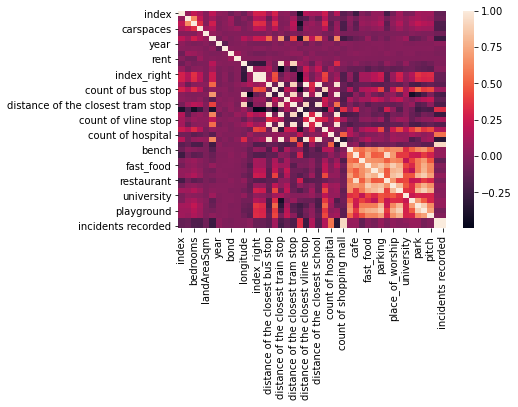

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = init_house.corr()
sns.heatmap(corr)

In [27]:
# Save merged data table to curated folder
# init_house.to_csv("../data/curated/init_house.csv")

#### 4. ABS Data: Population, income and Sex

##### 4.1 Data Reload

4.1.1 Population

In [694]:
house_df_n

,index,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance,school_count,school_distance,tram_distance,tram_count,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,offence count,incidents recorded
0,0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375,3,0.577,0.116,24,2.804,0,0,1.388,0,22895,17201
1,1,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730,3,0.299,0.111,24,2.442,0,0,1.714,0,22895,17201
2,2,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766,3,0.579,0.059,24,2.751,0,0,1.927,0,22895,17201
3,3,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209,3,0.165,0.139,24,3.457,0,0,1.304,0,22895,17201
4,4,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,144.949687,-37.837520,POINT (144.94969 -37.83752),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143,3,0.475,0.394,24,3.544,0,0,1.370,0,22895,17201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113161,113161,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,147.493795,-36.536581,POINT (147.49379 -36.53658),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.649,2,10.219,249.694,0,233.799,0,0,68.639,0,302,230
113162,113162,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,147.494529,-36.536194,POINT (147.49453 -36.53619),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.627,2,10.283,249.772,0,233.877,0,0,68.662,0,302,230
113163,113163,['house'],1.0,3.0,2.0,2022-08-31T04:22:36.17Z,2022-08-18T06:04:32Z,"{""latitude"": -36.2218206, ""longitude"": 147.258...",NaN,3700,tallangatta,2022,8,$470,NaN,470.0,147.258393,-36.221821,POINT (147.25839 -36.22182),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7.265,3,7.593,253.141,0,240.828,0,1,32.738,0,605,484
113164,113164,['house'],1.0,3.0,2.0,2021-03-09T00:53:53.08Z,2021-02-15T22:36:56Z,"{""latitude"": -36.2147158, ""longitude"": 147.177...",NaN,3700,tallangatta,2021,3,$310 per week,NaN,310.0,147.177222,-36.214716,POINT (147.17722 -36.21472),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.234,3,0.271,248.167,0,236.377,0

In [695]:
population = pd.read_csv('../data/population_forcasting.csv')
population

,Unnamed: 0,year,area_code,Total,SA2 code,SA2 name,Postcode
0,0,2001,21001,5756,21001,Alfredton,3350.0
1,0,2022,21001,18235,21001,Alfredton,3350.0
2,1,2001,21002,11497,21002,Ballarat,3350.0
3,1,2023,21001,19815,21002,Ballarat,3350.0
4,2,2001,21003,20268,21003,Ballarat - North,3350.0
...,...,...,...,...,...,...,...
11877,9697,2021,21476,3978,21476,Otway,NaN
11878,9698,2021,21477,6989,21477,Moyne - East,NaN
11879,9699,2021,21478,9963,21478,Moyne - West,NaN
11880,9700,2021,21479,22462,21479,Warrnambool - North,NaN


In [697]:
house_df_n

,index,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance,school_count,school_distance,tram_distance,tram_count,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,offence count,incidents recorded
0,0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375,3,0.577,0.116,24,2.804,0,0,1.388,0,22895,17201
1,1,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730,3,0.299,0.111,24,2.442,0,0,1.714,0,22895,17201
2,2,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766,3,0.579,0.059,24,2.751,0,0,1.927,0,22895,17201
3,3,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209,3,0.165,0.139,24,3.457,0,0,1.304,0,22895,17201
4,4,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,144.949687,-37.837520,POINT (144.94969 -37.83752),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143,3,0.475,0.394,24,3.544,0,0,1.370,0,22895,17201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113161,113161,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,147.493795,-36.536581,POINT (147.49379 -36.53658),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.649,2,10.219,249.694,0,233.799,0,0,68.639,0,302,230
113162,113162,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,147.494529,-36.536194,POINT (147.49453 -36.53619),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.627,2,10.283,249.772,0,233.877,0,0,68.662,0,302,230
113163,113163,['house'],1.0,3.0,2.0,2022-08-31T04:22:36.17Z,2022-08-18T06:04:32Z,"{""latitude"": -36.2218206, ""longitude"": 147.258...",NaN,3700,tallangatta,2022,8,$470,NaN,470.0,147.258393,-36.221821,POINT (147.25839 -36.22182),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7.265,3,7.593,253.141,0,240.828,0,1,32.738,0,605,484
113164,113164,['house'],1.0,3.0,2.0,2021-03-09T00:53:53.08Z,2021-02-15T22:36:56Z,"{""latitude"": -36.2147158, ""longitude"": 147.177...",NaN,3700,tallangatta,2021,3,$310 per week,NaN,310.0,147.177222,-36.214716,POINT (147.17722 -36.21472),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.234,3,0.271,248.167,0,236.377,0

In [716]:
population = pd.read_excel('../data/Population.xlsx', sheet_name="Pop", header=[0,1])
house_df2 = house_df_n.merge(population, how="left", left_on=["SA2_maincode_2021"], right_on=[(           'Unnamed: 0_level_0', 'SA2 code')])
house_df2

,index,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance,school_count,school_distance,tram_distance,tram_count,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,offence count,incidents recorded,"(Unnamed: 0_level_0, SA2 code)","(Unnamed: 1_level_0, SA2 name)","(Population , 2019)","(Population , 2020)","(Population , 2021)","(Population , 2022)","(Population Increase, 2019)","(Population Increase, 2020)","(Population Increase, 2021)","(Population Increase, 2022)"
0,0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375,3,0.577,0.116,24,2.804,0,0,1.388,0,22895,17201,206051512,South Melbourne,12753,12707,11860,11758.973851,0.003541,-0.003607,-0.066656,-0.008518
1,1,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730,3,0.299,0.111,24,2.442,0,0,1.714,0,22895,17201,206051512,South Melbourne,12753,12707,11860,11758.973851,0.003541,-0.003607,-0.066656,-0.008518
2,2,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766,3,0.579,0.059,24,2.751,0,0,1.927,0,22895,17201,206051512,South Melbourne,12753,12707,11860,11758.973851,0.003541,-0.003607,-0.066656,-0.008518
3,3,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209,3,0.165,0.139,24,3.457,0,0,1.304,0,22895,17201,206051512,South Melbourne,12753,12707,11860,11758.973851,0.003541,-0.003607,-0.066656,-0.008518
4,4,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,144.949687,-37.837520,POINT (144.94969 -37.83752),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143,3,0.475,0.394,24,3.544,0,0,1.370,0,22895,17201,206051512,South Melbourne,12753,12707,11860,11758.973851,0.003541,-0.003607,-0.066656,-0.008518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113161,113161,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,147.493795,-36.536581,POINT (147.49379 -36.53658),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.649,2,10.219,249.694,0,233.799,0,0,68.639,0,302,230,204031072,Towong,6109,6132,6153,6181.185987,0.006094,0.003765,0.003425,0.004581
113162,113162,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,14

4.1.1 Income

In [699]:
income = pd.read_excel('../data/Income.xlsx',sheet_name="Forecasted Income", header=[0,1]).drop([(           'Unnamed: 0_level_0',      'SA2')], axis = 1)
income[(           'Unnamed: 2_level_0', 'Postcode')] = income[(           'Unnamed: 2_level_0', 'Postcode')].fillna(0)
name_income_dict = dict()
postcode_income_dict = dict()
for index, item in income.iterrows():
    name = item[(           'Unnamed: 1_level_0', 'SA2 NAME')].lower().replace('- ','')
    postcode_income = int(item[(           'Unnamed: 2_level_0', 'Postcode')])
    name_income_dict[name] = item
    postcode_income_dict[postcode_income] = item

def search_income(suburb_name,postcode):
    item = name_income_dict.get(suburb_name)
    if item is not None:
        return item
    item = postcode_income_dict.get(postcode)
    if item is not None:
        return item    
    return None


In [700]:
income_list = []
l = []
col = None
for index, value in house_df2.iterrows():
    item = search_income(value['surburb'], value['postcode'])
    if item is not None:
        l.append(list(item))
        col = item.index
    else:
        l.append([None]*len(col))


In [717]:
income = pd.DataFrame(l, columns=['SA2 NAME','Postcode','Earners_2019','Earners_2020','Earners_2021','Earners_2022','Median_age_2019','Median_age_2020','Median_age_2021','Median_age_2022','sum_2019','sum_2020','sum_2021','sum_2022','median_2019','median_2020','median_2021','median_2022','mean_2019','mean_2020','mean_2021','mean_2022'])
house_original = pd.concat([house_df2, income],axis=1)
# house = house_original.fillna(0)
value_list = []
for index, values in house_original.iterrows():
    year = values['year']
    column_list = list(values.index)[:57]
    for i in list(values.index)[57:]:
        if str(year) in i:
            column_list.append(i)
    new_value = values[column_list]
    value_list.append(list(new_value))
file = pd.DataFrame(value_list, columns = column_list).rename({'Earners_2021':'Earners', 'Median_age_2021':'Median_age', 'sum_2021':'sum', 'median_2021':'median',	'mean_2021':'mean'}, axis = 1)

In [734]:
file.columns[57]

'Earners'

In [735]:
value_list = []
for index, values in file.iterrows():
    year = values['year']
    column_list = list(values.index)[:48]
    column_list.extend(list(file.columns)[57:])
    for i in list(values.index)[49:57]:
        if i[1] == year:
            column_list.append(i)
    new_value = values[column_list]
    value_list.append(list(new_value))
# file = pd.DataFrame(value_list, columns = column_list).rename({'Earners_2021':'Earners', 'Median_age_2021':'Median_age', 'sum_2021':'sum', 'median_2021':'median',	'mean_2021':'mean'}, axis = 1)

In [736]:
value_list = pd.DataFrame(value_list,columns = column_list)
value_list
value_list_2 = value_list.rename({('Population ', 2021):'population'}, axis = 1)
value_list_2 = value_list_2.rename({('Population Increase', 2021):'population_increase'}, axis = 1)
value_list_2

,index,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance,school_count,school_distance,tram_distance,tram_count,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,offence count,incidents recorded,Earners,Median_age,sum,median,mean,population,population_increase
0,0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,144.960873,-37.834163,POINT (144.9608734 -37.8341628),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375,3,0.577,0.116,24,2.804,0,0,1.388,0,22895,17201,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,12753.000000,0.003541
1,1,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,144.964862,-37.835075,POINT (144.9648624 -37.8350754),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730,3,0.299,0.111,24,2.442,0,0,1.714,0,22895,17201,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,12753.000000,0.003541
2,2,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,144.960818,-37.840217,POINT (144.9608179 -37.8402171),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766,3,0.579,0.059,24,2.751,0,0,1.927,0,22895,17201,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,12753.000000,0.003541
3,3,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,144.953039,-37.836653,POINT (144.9530393 -37.8366529),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209,3,0.165,0.139,24,3.457,0,0,1.304,0,22895,17201,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,12753.000000,0.003541
4,4,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,144.949687,-37.837520,POINT (144.9496869 -37.8375202),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143,3,0.475,0.394,24,3.544,0,0,1.370,0,22895,17201,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,12753.000000,0.003541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113161,113161,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,147.493795,-36.536581,POINT (147.4937949 -36.5365807),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.649,2,10.219,249.694,0,233.799,0,0,68.639,0,302,230,4963.045082,47.856776,2.293470e+08,44583.025987,45276.629966,6181.185987,NaN
113162,113162,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,147.494529,-36.536194,POINT (147.4945295 -36.5361943),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.627,2,10.283,249.772,0,233.877,0,0,68.662,0,302,230,4963.045082,47.856776,2.293470e+08,44583.025987,45276.629966,6181.185987,NaN
113163,1

4.1.3 Sex Ratio

In [259]:
sex_ratio = pd.read_excel('../data/Sex & Age by Year.xlsx', sheet_name="Ratio", header=[0,1])
sex_ratio.head(3)

Unnamed: 0_level_0   Male                             Female                \
                 SA2   2019   2020   2021          2022   2019   2020   2021   
0          201011001   7077   7590   8238   8827.102822   7331   7882   8585   
1          201011002   5874   5780   5695   5663.004769   6437   6403   6381   
2          201011003  11666  11689  11703  11785.855145  12569  12610  12645   

                Person                             Male Ratio            \
           2022   2019   2020   2021          2022       2019      2020   
0   9217.148629  14408  15472  16823  18044.196846   0.491185  0.490564   
1   6368.892049  12311  12183  12076  12031.700652   0.477134  0.474432   
2  12727.455494  24235  24299  24348  24513.296862   0.481370  0.481049   

                      Female Ratio                                
       2021      2022         2019      2020      2021      2022  
0  0.489687  0.489193     0.508815  0.509436  0.510313  0.510810  
1  0.471597  0.470674     0.522866  0.525568  0.528403  0.529343  
2  0.480655  0.480794     0.518630  0.518951  0.519345  0.519206

##### 4.2 Join All

In [260]:
merge_data = population.merge(income, how="left", left_on= [('Unnamed: 0_level_0', 'SA2 code')], right_on=[(           'Unnamed: 0_level_0',      'SA2')])
merge_data = merge_data.merge(sex_ratio, how="left", left_on= [('Unnamed: 0_level_0', 'SA2 code')], right_on=[('Unnamed: 0_level_0', 'SA2')])
merge_data.drop(columns=["Unnamed: 0_level_0_x", "Unnamed: 1_level_0","Unnamed: 2_level_0","Unnamed: 0_level_0_y"],errors='raise',inplace=True)

In [261]:
merge_data.head(3)

Unnamed: 0_level_0 Population                               \
            SA2 code        2019   2020   2021          2022   
0          201011001       14408  15472  16823  18044.196846   
1          201011002       12311  12183  12076  12031.700652   
2          201011005        7452   7369   7232   7216.773205   

  Population Increase                               Earners (persons)  \
                 2019      2020      2021      2022              2019   
0            0.065680  0.073848  0.087319  0.072591       8503.447540   
1            0.006047 -0.010397 -0.008783 -0.003668       7673.610510   
2            0.005261 -0.011138 -0.018591 -0.002105       4322.973567   

                                          Median age of earners (years)  \
          2020         2021          2022                          2019   
0  9019.555013  9567.571661  10148.885100                     42.000000   
1  7743.676448  7813.745816   7813.745816                     47.516546   
2  4407.512769  4483.031429   4483.031429                     46.255556   

                                         Sum ($)                              \
        2020       2021       2022          2019          2020          2021   
0  42.000000  42.000000  42.000000  5.581284e+08  6.112807e+08  6.684159e+08   
1  47.744301  48.030360  48.390075  6.203439e+08  6.428705e+08  6.724473e+08   
2  46.657079  47.163341  47.541016  2.794734e+08  2.924104e+08  3.049772e+08   

                   Median ($)                                            \
           2022          2019          2020          2021          2022   
0  7.295697e+08  55374.162543  56981.756185  58628.439829  60284.180114   
1  7.019395e+08  55244.566537  56765.110158  58475.016103  60293.138457   
2  3.179211e+08  53825.456103  55531.685800  57244.683920  58912.175016   

       Mean ($)                                              Male          \
           2019          2020          2021          2022    2019    2020   
0  65636.394852  67773.311518  69862.748812  71889.039229  7077.0  7590.0   
1  80837.265352  83014.858813  86055.212890  89164.155659  5874.0  5780.0   
2  64645.372883  66339.339696  68023.775165  69741.827133  3835.0  3737.0   

                        Female                                Person           \
     2021         2022    2019    2020    2021         2022     2019     2020   
0  8238.0  8827.102822  7331.0  7882.0  8585.0  9217.148629  14408.0  15472.0   
1  5695.0  5663.004769  6437.0  6403.0  6381.0  6368.892049  12311.0  12183.0   
2  3587.0  3561.736818  3617.0  3632.0  3645.0  3656.101969   7452.0   7369.0   

                         Male Ratio                                \
      2021          2022       2019      2020      2021      2022   
0  16823.0  18044.196846   0.491185  0.490564  0.489687  0.489193   
1  12076.0  12031.700652   0.477134  0.474432  0.471597  0.470674   
2   7232.0   7216.773205   0.514627  0.507124  0.495990  0.493536   

  Female Ratio                                
          2019      2020      2021      2022  
0     0.508815  0.509436  0.510313  0.510810  
1     0.522866  0.525568  0.528403  0.529343  
2     0.485373  0.492876  0.504010  0.506612

##### 4.3 Add features to main table
1. Create SA2 code mapping on main table using postcode2sa2 data.
2. Merge feature from feature table back to main by SA2

In [262]:
init_house = init_house.merge(merge_data, how="left", left_on=["SA2_maincode_2021"], right_on=[(           'Unnamed: 0_level_0', 'SA2 code')])

In [723]:
value_list_2.columns

Index(['index', 'propertyTypes', 'bathrooms', 'bedrooms', 'carspaces',
       'dateUpdated', 'dateListed', 'geoLocation', 'landAreaSqm', 'postcode',
       'surburb', 'year', 'month', 'price', 'bond', 'rent', 'longitude',
       'latitude', 'geometry', 'index_right', 'SA2_maincode_2021', 'bench',
       'cafe', 'childcare', 'fast_food', 'kindergarten', 'parking',
       'restaurant', 'place_of_worship', 'school', 'university', 'garden',
       'park', 'playground', 'pitch', 'bus_count', 'bus_distance',
       'school_count', 'school_distance', 'tram_distance', 'tram_count',
       'train_distance', 'train_count', 'hospital_count',
       'shopping_mall_distance', 'shopping_mall_count', 'offence count',
       'Earners', 'Median_age', 'sum', 'median', 'mean', 'population',
       'population_increase'],
      dtype='object')

In [737]:
value_list_2.to_csv("../data/prepared_data.csv")